In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm

from scipy.signal import convolve, fftconvolve, windows
from scipy import ndimage

import functools

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
CosmoParams_use,ClassyCosmo_use, CorrFclass_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)
AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)

# average SFRD
bar_SFRD = CoeffStructure_21_use.SFRDbar2D_II

CoeffStructure_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_use, CoeffStructure_use, RSD_MODE = RSDMODE)


In [3]:
def get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass):

    Nsigmad = 5.0 #how many sigmas we explore
    Nds = 150 #how many deltas

    # define \delta_R
    deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)

    # this is just for dimensions
    zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
    # rArray is between 0.5 to 2000 Mpc, for integration 
    rGreaterArray = np.zeros_like(zArray) + rArray
    rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
    zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)

    # variance smoothed over R > Rh
    sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
    whereNotNans = np.invert(np.isnan(rGreaterArray))
    sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

    # tilde delta 
    deltaArray = deltaNormArray * sigmaR

    return deltaArray, sigmaR, deltatab_norm, rArray

In [4]:
def SFRD_from_deltaR(CoeffStructure_21,CosmoParams,HMFintclass,AstroParams):

    # tilde delta 
    deltaArray, sigmaR, deltatab_norm, _ = get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass)

    # this is just for dimensions
    zArray, rArray, mArray, _ = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
    # rArray is between 0.5 to 2000 Mpc, for integration 
    rGreaterArray = np.zeros_like(zArray) + rArray
    rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
    zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)


    # variance smoothed over Rh = R(M_h) with Mh between 1e5 and 1e14 
    sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zGreaterArray))
    
    # tilde sigma
    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    # define the correction from the EPS HMF
    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray
    nu = modd / modSigma
    C_arb = 1.6
    EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)

    # integrand of the SFRD
    integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)
        
    SFRD_II_dR = np.trapezoid(integrand_II, HMFintclass.logtabMh, axis = 2) 

    return SFRD_II_dR

In [5]:
def SFRD_approx(deltaArray, CoeffStructure_21):

    use_gamma = CoeffStructure_21.gamma_II_index2D[:,:,np.newaxis]
    SFRD_deltaR =  np.exp(use_gamma * deltaArray) 

    return SFRD_deltaR

In [56]:
def SFRD_box(Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams):
    
    Mapz12 = zeus21.CoevalMaps(CoeffStructure21, PS21, 12., KIND=1,Lbox=Lbox,Nbox=Nbox) #can set Lbox, Nbox, and seed

    delta_box = Mapz12.deltamap

    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    deltabox_flattened = (delta_box * sigmaR).flatten()

    zArray, mArray, deltaArray = np.meshgrid(CoeffStructure21.zintegral, HMFintclass.Mhtab, deltabox_flattened, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zArray))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray
    nu = modd / modSigma
    C_arb = 1.6
    EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray), zArray)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, zArray, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[np.newaxis,:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 1) 

    SFRD_box = SFRDbox_flattend.reshape(len(zArray),Nbox,Nbox,Nbox)
    delta_box_sigmaR = deltaArray.reshape(Nbox,Nbox,Nbox)

    return delta_box_sigmaR, SFRD_box

In [78]:
def SFRD_R(R,Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams):

    density_vals, SFRD_box_vals = SFRD_box(Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams)
    if R < Lbox/Nbox:
        print('\n\nYou cannot smooth over R smaller than the cell size!!!\n\n')
        return density_vals,SFRD_box_vals
    elif R > Lbox:
        print('\n\nYou cannot smooth over R larger than the box size!!!\n\n')
        return density_vals,SFRD_box_vals
 
    input_ = np.fft.fftn(density_vals)
    result_fft = ndimage.fourier_gaussian(input_, sigma= R / 3./(2 * np.sqrt(2 * np.log(2))))
    density_smoothed_R = np.abs(np.fft.ifftn(result_fft)) * np.sign(density_vals)

    SFRD_smoothed_R_z = []
    for zv in tqdm(range(len(SFRD_box_vals))):

        input_ = np.fft.fftn(SFRD_box_vals[zv])
        result_fft = ndimage.fourier_gaussian(input_, sigma= R / 3./(2 * np.sqrt(2 * np.log(2))))
        SFRD_smoothed_R_z.append(np.abs(np.fft.ifftn(result_fft)))

    return np.asarray(density_smoothed_R), np.asarray(SFRD_smoothed_R_z)

In [79]:
# tilde delta 
temp = get_deltaR_sigmaR(CoeffStructure_21_use,CosmoParams_use,HMFintclass_use)
deltaArray_use = np.squeeze(temp[0])
sigmaR = np.squeeze(temp[1])
R_use = np.squeeze(temp[-1])

In [106]:
zid = 0
z = round(CoeffStructure_21_use.zintegral[zid],0)
zid1 = 21
z1 = round(CoeffStructure_21_use.zintegral[zid1],0)
Rid = 15 #10
R = int(round(R_use[Rid],0))

In [107]:
Lbox = 150
Nbox = 60
map_delta, map_SFRD_z = SFRD_box(Lbox,Nbox,PS21=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use)

smoothed_map_delta_z, smoothed_map_SFRD_z  = SFRD_R(R,Lbox,Nbox,PS21=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use)

map_SFRD = np.log10(map_SFRD_z[zid])
smoothed_map_SFRD = np.log10(smoothed_map_SFRD_z[zid])
#map_SFRD1 = np.log10(map_SFRD_z[zid1])

100%|██████████| 64/64 [00:01<00:00, 37.09it/s]


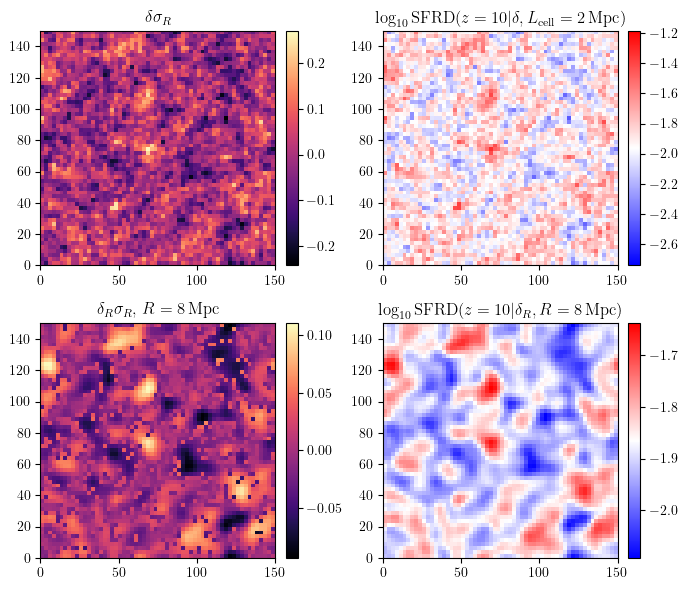

In [108]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))

_islice = 0

im = ax[0,0].imshow(map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='magma')#,vmin=-0.6,vmax=0.6) 
cbar1 = fig.colorbar(im, ax=ax[0,0], fraction=0.046, pad=0.04)
ax[0,0].set_title(r'$\delta\sigma_R$')

im = ax[0,1].imshow(map_SFRD[_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',vmin=np.min(map_SFRD),vmax=np.max(map_SFRD))
cbar1 = fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04)
ax[0,1].set_title(r'$\log_{10}{\rm SFRD}(z=%g$'%z+r'$|\delta,L_{\rm cell}=%g\,{\rm Mpc})$'%round(Lbox/Nbox,0))

im = ax[1,0].imshow(smoothed_map_delta_z[_islice],extent=(0,Lbox,0,Lbox),cmap='magma')#,vmin=-0.6,vmax=0.6) 
cbar1 = fig.colorbar(im, ax=ax[1,0], fraction=0.046, pad=0.04)
ax[1,0].set_title(r'$\delta_R\sigma_R,\,R=%g\,{\rm Mpc}$'%R)

im = ax[1,1].imshow(smoothed_map_SFRD[_islice],extent=(0,Lbox,0,Lbox),cmap='bwr')#,vmin=np.min(map_SFRD),vmax=np.max(map_SFRD)) 
cbar1 = fig.colorbar(im, ax=ax[1,1], fraction=0.046, pad=0.04)
ax[1,1].set_title(r'$\log_{10}{\rm SFRD}(z=%g|$'%z+r'$\delta_R, R = %g\,{\rm Mpc})$'%R)

fig.tight_layout()
plt.show()


In [109]:
def binned_SFRD_R(delta, delta_R, sfr):

    # Step 1: Calculate the bin edges based on delta_R central points
    bin_edges = np.zeros(len(delta_R) + 1)
    bin_edges[0] = delta_R[0] - (delta_R[1] - delta_R[0]) / 2  # Edge before first central point
    bin_edges[-1] = delta_R[-1] + (delta_R[-1] - delta_R[-2]) / 2  # Edge after last central point

    # Fill the interior edges (midpoints between consecutive central points)
    for i in range(1, len(delta_R)):
        bin_edges[i] = (delta_R[i-1] + delta_R[i]) / 2

    # Step 2: Use np.digitize to get the bin indices for delta values based on bin_edges
    bin_indices = np.digitize(delta, bin_edges) - 1  # Subtract 1 to get correct indices (1-based to 0-based)

    # Step 3: Initialize a new array to store binned sfr values (based on delta's bins)
    binned_sfr = np.zeros((len(delta_R), *delta.shape))  # One bin for each central point in delta_R
    binned_sfr_mean = np.zeros((len(delta_R)))  # One bin for each central point in delta_R

    # Step 4: Bin the sfr values according to the bin indices of delta
    for i in range(len(delta_R)):
        binned_sfr[i] = np.where(bin_indices == i, sfr, 0)  # Assign sfr values to corresponding bins

    # Now, binned_sfr contains the values of sfr binned according to delta
    # Each element in binned_sfr[i] corresponds to the sfr values that fall into the ith bin of delta_R

        # Optionally: You can aggregate the values in each bin, e.g., by computing the mean
        binned_sfr_mean[i] = np.max(binned_sfr[i])

    return binned_sfr_mean


In [110]:
SFRD_1 = SFRD_from_deltaR(CoeffStructure_21_use,CosmoParams_use,HMFintclass_use,AstroParams_use)

# SFRD(z|delta_R) / SFRD when z = z[zid] , R = R[Rid]
SFRD_II_dR = (SFRD_1[zid,Rid] / bar_SFRD[zid,Rid])

# SFRD(z|delta_R) / SFRD when z = z[zid1] , R = R[Rid]
SFRD_II_dR1 = (SFRD_1[zid1,Rid] /bar_SFRD[zid1,Rid])


In [111]:
# exponential approximation when z = z[zid1] , R = R[Rid]
SFRD_deltaR =  SFRD_approx(deltaArray_use, CoeffStructure_21_use)[zid,Rid,:]

# exponential approximation when z = z[zid1] , R = R[Rid]
SFRD_deltaR1 =  SFRD_approx(deltaArray_use,CoeffStructure_21_use)[zid1,Rid,:]

In [112]:
SFRD_mine = binned_SFRD_R(smoothed_map_delta_z, deltaArray_use[zid,Rid], smoothed_map_SFRD_z[zid]) / np.mean(smoothed_map_SFRD_z[zid])
SFRD_mine1 = binned_SFRD_R(smoothed_map_delta_z, deltaArray_use[zid1,Rid],  smoothed_map_SFRD_z[zid1])/ np.mean(smoothed_map_SFRD_z[zid1])

(0.01, 20.0)

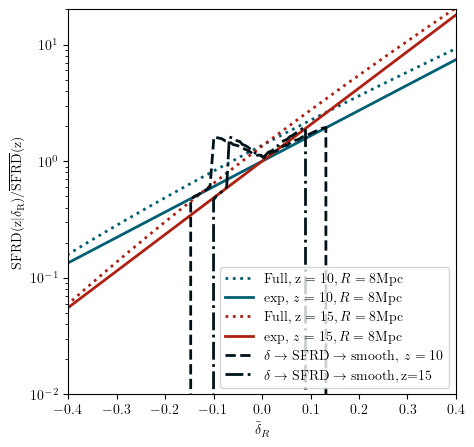

In [113]:
plt.figure(figsize=(11,5))

plt.subplot(121)

plt.semilogy(deltaArray_use[zid,Rid],SFRD_II_dR,label=r'$\rm Full,\, z=%g$'%z + r'$, R =%g {\rm Mpc}$'%R,color=colors[1],linestyle=':')
plt.semilogy(deltaArray_use[zid,Rid],SFRD_deltaR,label=r'$\exp,\, z=%g$'%z + r'$, R =%g {\rm Mpc}$'%R,color=colors[1])

plt.semilogy(deltaArray_use[zid1,Rid],SFRD_II_dR1,label=r'$\rm Full,\, z=%g$'%z1 + r'$, R =%g  {\rm Mpc}$'%R,color=colors[-2],linestyle=':')
plt.semilogy(deltaArray_use[zid1,Rid],SFRD_deltaR1,label=r'$\exp,\, z=%g$'%z1 + r'$, R =%g {\rm Mpc}$'%R,color=colors[-2])

plt.semilogy(deltaArray_use[zid,Rid],SFRD_mine,color=colors[0],ls='--', label=r'$\delta\to{\rm SFRD}\to{\rm smooth},\,z=%g$'%z)
plt.semilogy(deltaArray_use[zid1,Rid],SFRD_mine,color=colors[0], ls='-.',label=r'$\delta\to{\rm SFRD}\to{\rm smooth}$,\,z=%g'%z1)

plt.legend(loc=4)
plt.ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
plt.xlabel(r'$\tilde{\delta}_R$')

plt.xlim(-0.4,0.4)
plt.ylim(1e-2,2e1)